# BINARY BLACK HOLE SIGNALS IN LIGO OPEN DATA 

Version 1.63, 2017 Sept 11

Welcome! This IPython notebook (or associated python script LOSC_Event_tutorial.py ) will go through some typical signal processing tasks on strain time-series data associated with the LIGO Event data releases from the LIGO Open Science Center (LOSC):

* Find events at https://losc.ligo.org/events/.
* View the tutorial as a <a href='https://losc.ligo.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html'>web page, for GW150914</a>.
* Run this tutorial with Binder using the link on the <a href="https://losc.ligo.org/tutorials/">tutorials</a> page.
* If you are running this tutorial on your own computer, see the <a href="#Download-the-data">Download</a> section below.
* This notebook works with nbformat version 4. If you are running version 3, pick it up from the <a href="https://losc.ligo.org/tutorials/">tutorials</a> page.
* After setting the desired "eventname" below, you can just run the full notebook.

Questions, comments, suggestions, corrections, etc: email losc@ligo.caltech.edu

## This tutorial is intended for educational purposes.  The code shown here is not used to produce results papers published by the LIGO Scientific Collaboration, which instead rely on special purpose analysis software packages.
### For publicly available, gravitational-wave software analysis packages that are used to produce LSC and Virgo Collaboration results papers, see https://losc.ligo.org/software/.  
### For technical notes on this tutorial, see https://losc.ligo.org/bbh_tutorial_notes/.

## Table of Contents
* <a href='#Intro-to-signal-processing'>Intro to signal processing</a>
* <a href='#Download-the-data-on-a-computer-with-a-python-installation'>Download the data</a>
* <a href='#Set-the-event-name-to-choose-event-and-the-plot-type'>Set the event name to choose event and the plot type</a>
* <a href='#Read-in-the-data'>Read in the data</a>
* <a href='#Plot-the-Amplitude-Spectral-Density-(ASD)'>Plot the ASD</a>
* <a href='#Binary-Neutron-Star-(BNS)-detection-range'>Binary Neutron Star detection range</a>
* <a href='#Whitening'>Whitening</a>
* <a href='#Spectrograms'>Spectrograms</a>
* <a href='#Waveform-Template'>Waveform Template</a>
* <a href='#Matched-filtering-to-find-the-signal'>Matched filtering to find the signal</a>
* <a href='#Make-sound-files'>Make sound Files</a>
* <a href='#Data-segments'>Data segments</a>

## Intro to signal processing

This tutorial assumes that you are comfortable with <a href="https://www.python.org/">python</a>.

This tutorial also assumes that you know a bit about signal processing of digital time series data (or want to learn!). This includes power spectral densities, spectrograms, digital filtering, whitening, audio manipulation. This is a vast and complex set of topics, but we will cover many of the basics in this tutorial.

If you are a beginner, here are some resources from the web:
* http://101science.com/dsp.htm
* https://www.coursera.org/course/dsp
* https://georgemdallas.wordpress.com/2014/05/14/wavelets-4-dummies-signal-processing-fourier-transforms-and-heisenberg/
* https://en.wikipedia.org/wiki/Signal_processing
* https://en.wikipedia.org/wiki/Spectral_density
* https://en.wikipedia.org/wiki/Spectrogram
* http://greenteapress.com/thinkdsp/
* https://en.wikipedia.org/wiki/Digital_filter

And, well, lots more on the web!

## Download the data on a computer with a python installation

If you are using a pre-configured setup (eg, in binder), great! You don't have to download or set up anything.

Otherwise, to begin, get the necessary files, by downloading the zip file and unpacking it into single directory:
* <a href='https://losc.ligo.org/s/events/LOSC_Event_tutorial.zip'>LOSC_Event_tutorial.zip</a>

This zip file contains:

* this IPython notebook LOSC_Event_tutorial.ipynb, and LOSC_Event_tutorial.py code. 
* python code for reading LOSC data files: <a href='https://losc.ligo.org/s/sample_code/readligo.py'>readligo.py</a>. 
* the event data files (32s sampled at 4096 Hz, in hdf5 format, for both LIGO detectors).
* waveform templates (32s sampled at 4096 Hz, in hdf5 format, for both plus and cross polarizations).
* a parameter file in json format

You will also need a python installation with a few packages (<a href="http://www.numpy.org/">numpy</a>, <a href="http://matplotlib.org/">matplotlib</a>, <a href="https://www.scipy.org/">scipy</a>, <a href="http://www.h5py.org/">h5py</a>,  <a href="https://docs.python.org/2/library/json.html">json</a> ).

* For hints on software installation, see https://losc.ligo.org/tutorial00/
* The tutorial should work on python 2.6 and above, including python 3, as well as in recent versions of Ipython.
* You *might* see Warning or FutureWarning messages, which tend to be associated with different versions of python, Ipython, numpy, etc. Hopefully they can be ignored!
* the filetype "hdf5" means the data are in hdf5 format:
https://www.hdfgroup.org/HDF5/
* NOTE: GPS time is number of seconds since Jan 6, 1980 GMT. See http://www.oc.nps.edu/oc2902w/gps/timsys.html or https://losc.ligo.org/gps/ 


## Set the event name to choose event and the plot type

In [1]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
eventname = ''
eventname = 'GW150914' 
#eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"

In [2]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
from ligotools import readligo as rl
from ligotools.utils import pcd_plot as pp
from ligotools.utils import *


# you might get a matplotlib warning here; you can ignore it.

### Read the event properties from a local json file (download in advance):

In [3]:
# Read the event properties from a local json file
fnjson = "data/BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

In [4]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{u'fband': [43.0, 300.0], u'approx': u'lalsim.SEOBNRv2', u'fs': 4096, u'name': u'GW150914', u'utcevent': u'2015-09-14T09:50:45.44', u'fn_H1': u'H-H1_LOSC_4_V2-1126259446-32.hdf5', u'a1': 0.355, u'fn_L1': u'L-L1_LOSC_4_V2-1126259446-32.hdf5', u'm1': 41.743, u'f_min': 10.0, u'fn_template': u'GW150914_4_template.hdf5', u'm2': 29.237, u'tevent': 1126259462.44, u'a2': -0.769}


## Read in the data
We will make use of the data, and waveform template, defined above.

In [5]:
#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata('data/'+fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata('data/'+fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()

ligotools/readligo.py:132: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
ligotools/readligo.py:138: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
ligotools/readligo.py:143: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


## Data Gaps
**NOTE** that in general, LIGO strain time series data has gaps (filled with NaNs) when the detectors are not taking valid ("science quality") data. Analyzing these data requires the user to 
 <a href='https://losc.ligo.org/segments/'>loop over "segments"</a> of valid data stretches. 

**In this tutorial, for simplicity, we assume there are no data gaps - this will not work for all times!**  See the 
<a href='https://losc.ligo.org/segments/'>notes on segments</a> for details.


## First look at the data from H1 and L1

In [6]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
 

('time_H1: len, min, mean, max = ', 131072, 1126259446.0, 1126259461.999878, 1126259477.9997559)
('strain_H1: len, min, mean, max = ', 131072, -7.044665943156067e-19, 5.895522509246437e-23, 7.706262192397465e-19)
('strain_L1: len, min, mean, max = ', 131072, -1.8697138664279764e-18, -1.0522332249909908e-18, -4.60035111311666e-20)
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


1126259462.44


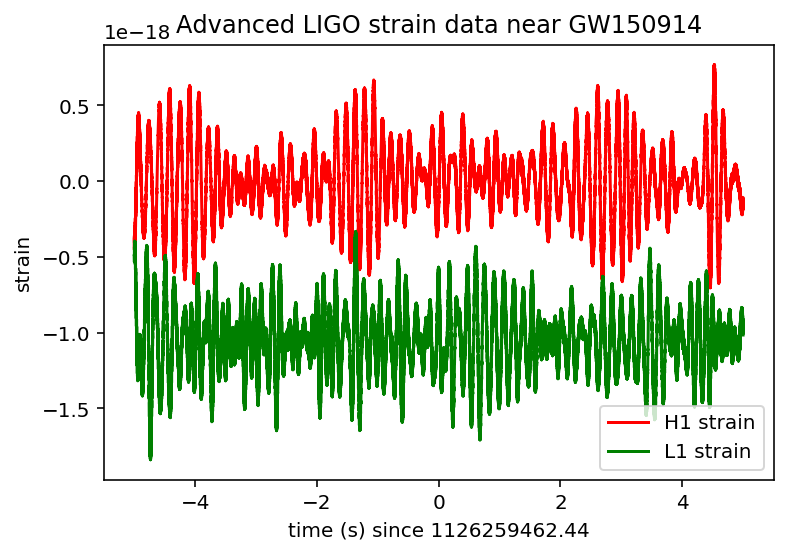

In [7]:
# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig("figurs/"+eventname+'_strain.'+plottype)

The data are dominated by **low frequency noise**; there is no way to see a signal here, without some signal processing.

## Plot the Amplitude Spectral Density (ASD)
Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency,
which limit the ability of the detectors to identify GW signals.

They are in units of strain/rt(Hz).
So, if you want to know the root-mean-square (rms) strain noise in a frequency band,
integrate (sum) the squares of the ASD over that band, then take the square-root.

There's a signal in these data! 
For the moment, let's ignore that, and assume it's all noise.

In [ ]:
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4*fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

if make_plots:
    # plot the ASDs, with the template overlaid:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(10,8))
    plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
    plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig("figurs/"+eventname+'_ASDs.'+plottype)

/home/jovyan/envs/ligo/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


NOTE that we only plot the data between f_min = 20 Hz and f_max = 2000 Hz.

Below f_min, the data **are not properly calibrated**. That's OK, because the noise is so high below f_min that LIGO cannot sense gravitational wave strain from astrophysical sources in that band.

The sample rate is fs = 4096 Hz (2^12 Hz), so the data cannot capture frequency content above the Nyquist frequency = fs/2 = 2048 Hz. That's OK, because our events only have detectable frequency content in the range given by fband, defined above; the upper end will (almost) always be below the Nyquist frequency. We set f_max = 2000, a bit below Nyquist.

You can see strong spectral lines in the data; they are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

You can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.

The smooth model is hard-coded and tuned by eye; it won't be right for arbitrary times. We will only use it below for things that don't require much accuracy.

## Binary Neutron Star (BNS) detection range

A standard metric that LIGO uses to evaluate the sensitivity of our detectors, based on the detector noise ASD, is the BNS range.

This is defined as the distance to which a LIGO detector can register a BNS signal with a single detector signal-to-noise ratio (SNR) of 8, averaged over source direction and orientation.  Here, SNR 8 is used as a nominal detection threshold, similar to typical CBC detection thresholds of SNR 6-8.

We take each neutron star in the BNS system to have a mass of 1.4 times the mass of the sun, and negligible spin.

GWs from BNS mergers are like "standard sirens"; we know their amplitude at the source from theoretical calculations. The amplitude falls off like 1/r, so their amplitude at the detectors on Earth tells us how far away they are. This is great, because it is hard, in general, to know the distance to astronomical sources.

The amplitude at the source is computed in the post-Newtonian "quadrupole approximation". This is valid for the inspiral phase only, and is approximate at best; there is no simple expression for the post-inspiral (merger and ringdown) phase. So this won't work for high-mass binary black holes like GW150914, which have a lot of signal strength in the post-inspiral phase.

But, in order to use them as standard sirens, we need to know the source direction and orientation relative to the detector and its "quadrupole antenna pattern" response to such signals. It is a standard (if non-trivial) computation to average over all source directions and orientations; the average amplitude is 1./2.2648 times the maximum value. 

This calculation is described in Appendix D of:
FINDCHIRP: An algorithm for detection of gravitational waves from inspiraling compact binaries
B. Allen et al., PHYSICAL REVIEW D 85, 122006 (2012) ; http://arxiv.org/abs/gr-qc/0509116


In [ ]:
BNS_range = 1
if BNS_range:
    #-- compute the binary neutron star (BNS) detectability range

    #-- choose a detector noise power spectrum:
    f = freqs.copy()
    # get frequency step size
    df = f[2]-f[1]

    #-- constants
    # speed of light:
    clight = 2.99792458e8                # m/s
    # Newton's gravitational constant
    G = 6.67259e-11                      # m^3/kg/s^2 
    # one parsec, popular unit of astronomical distance (around 3.26 light years)
    parsec = 3.08568025e16               # m
    # solar mass
    MSol = 1.989e30                      # kg
    # solar mass in seconds (isn't relativity fun?):
    tSol = MSol*G/np.power(clight,3)     # s
    # Single-detector SNR for detection above noise background: 
    SNRdet = 8.
    # conversion from maximum range (horizon) to average range:
    Favg = 2.2648
    # mass of a typical neutron star, in solar masses:
    mNS = 1.4

    # Masses in solar masses
    m1 = m2 = mNS    
    mtot = m1+m2  # the total mass
    eta = (m1*m2)/mtot**2  # the symmetric mass ratio
    mchirp = mtot*eta**(3./5.)  # the chirp mass (FINDCHIRP, following Eqn 3.1b)

    # distance to a fiducial BNS source:
    dist = 1.0                           # in Mpc
    Dist =  dist * 1.0e6 * parsec /clight # from Mpc to seconds

    # We integrate the signal up to the frequency of the "Innermost stable circular orbit (ISCO)" 
    R_isco = 6.      # Orbital separation at ISCO, in geometric units. 6M for PN ISCO; 2.8M for EOB 
    # frequency at ISCO (end the chirp here; the merger and ringdown follow) 
    f_isco = 1./(np.power(R_isco,1.5)*np.pi*tSol*mtot)
    # minimum frequency (below which, detector noise is too high to register any signal):
    f_min = 20. # Hz
    # select the range of frequencies between f_min and fisco
    fr = np.nonzero(np.logical_and(f > f_min , f < f_isco))
    # get the frequency and spectrum in that range:
    ffr = f[fr]

    # In stationary phase approx, this is htilde(f):  
    # See FINDCHIRP Eqns 3.4, or 8.4-8.5 
    htilde = (2.*tSol/Dist)*np.power(mchirp,5./6.)*np.sqrt(5./96./np.pi)*(np.pi*tSol)
    htilde *= np.power(np.pi*tSol*ffr,-7./6.)
    htilda2 = htilde**2

    # loop over the detectors
    dets = ['H1', 'L1']
    for det in dets:
        if det is 'L1': sspec = Pxx_L1.copy()
        else:           sspec = Pxx_H1.copy()
        sspecfr = sspec[fr]
        # compute "inspiral horizon distance" for optimally oriented binary; FINDCHIRP Eqn D2:
        D_BNS = np.sqrt(4.*np.sum(htilda2/sspecfr)*df)/SNRdet
        # and the "inspiral range", averaged over source direction and orientation:
        R_BNS = D_BNS/Favg
        print(det+' BNS inspiral horizon = {0:.1f} Mpc, BNS inspiral range   = {1:.1f} Mpc'.format(D_BNS,R_BNS))

## BBH range is >> BNS range!

NOTE that, since mass is the source of gravity and thus also of gravitational waves, systems with higher masses (such as the binary black hole merger GW150914) are much "louder" and can be detected to much higher distances than the BNS range. We'll compute the BBH range, using a template with specific masses, below.

## Whitening

From the ASD above, we can see that the data are very strongly "colored" - noise fluctuations are much larger at low and high frequencies and near spectral lines, reaching a roughly flat ("white") minimum in the band around 80 to 300 Hz.

We can "whiten" the data (dividing it by the noise amplitude spectrum, in the fourier domain), suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band.

Whitening is always one of the first steps in astrophysical data analysis (searches, parameter estimation).
Whitening requires no prior knowledge of spectral lines, etc; only the data are needed.

To get rid of remaining high frequency noise, we will also bandpass the data.

The resulting time series is no longer in units of strain; now in units of "sigmas" away from the mean.

We will plot the whitened strain data, along with the signal template, after the matched filtering section, below.

In [ ]:
whiten_data = 1
if whiten_data:
    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization

## Spectrograms

Now let's plot a short time-frequency spectrogram around our event:

In [ ]:
if make_plots:
    # index into the strain time series for this time interval:
    indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

    # pick a shorter FTT time interval, like 1/8 of a second:
    NFFT = int(fs/8)
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15./16)
    # and choose a window that minimizes "spectral leakage" 
    # (https://en.wikipedia.org/wiki/Spectral_leakage)
    window = np.blackman(NFFT)

    # the right colormap is all-important! See:
    # http://matplotlib.org/examples/color/colormaps_reference.html
    # viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
    #spec_cmap='viridis'
    spec_cmap='ocean'

    # Plot the H1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO H1 strain data near '+eventname)
    plt.savefig("figurs/"+eventname+'_H1_spectrogram.'+plottype)

    # Plot the L1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO L1 strain data near '+eventname)
    plt.savefig("figurs/"+eventname+'_L1_spectrogram.'+plottype)


In the above spectrograms, you may see lots of excess power below ~20 Hz, as well as strong spectral lines at 500, 1000, 1500 Hz (also evident in the ASDs above). The lines at multiples of 500 Hz are the harmonics of the "violin modes" of the fibers holding up the mirrors of the Advanced LIGO interferometers.

Now let's zoom in on where we think the signal is, using the whitened data, in the hope of seeing a chirp:

In [ ]:
if make_plots:
    #  plot the whitened data, zooming in on the signal region:

    # pick a shorter FTT time interval, like 1/16 of a second:
    NFFT = int(fs/16.0)
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15/16.0)
    # choose a window that minimizes "spectral leakage" 
    # (https://en.wikipedia.org/wiki/Spectral_leakage)
    window = np.blackman(NFFT)

    # Plot the H1 whitened spectrogram around the signal
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-0.5, 0.5, 0, 500])
    plt.title('aLIGO H1 strain data near '+eventname)
    plt.savefig("figurs/"+eventname+'_H1_spectrogram_whitened.'+plottype)

    # Plot the L1 whitened spectrogram around the signal
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_L1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-0.5, 0.5, 0, 500])
    plt.title('aLIGO L1 strain data near '+eventname)
    plt.savefig("figurs/"+eventname+'_L1_spectrogram_whitened.'+plottype)


Loud (high SNR) signals may be visible in these spectrograms.  Compact object mergers show a characteristic "chirp" as the signal rises in frequency.  If you can't see anything, try
<a href='https://losc.ligo.org/events/GW150914/'>event GW150914</a>, by changing the `eventname` variable in the first cell above.

## Waveform Template

The results of a full LIGO-Virgo analysis of this BBH event include a set of parameters that are consistent with a range of parameterized waveform templates. Here we pick one for use in matched filtering. 

As noted above, the results won't be identical to what is in the LIGO-Virgo papers, since we're skipping many subtleties, such as combining many consistent templates.

In [ ]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File("data/"+fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()

In [ ]:
# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

# whiten the templates:
template_p_whiten = whiten(template_p,psd_H1,dt)
template_c_whiten = whiten(template_c,psd_H1,dt)
template_p_whitenbp = filtfilt(bb, ab, template_p_whiten) / normalization
template_c_whitenbp = filtfilt(bb, ab, template_c_whiten) / normalization

# Compute, print and plot some properties of the template:

# constants:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg

# template parameters: masses in units of MSol:
t_mtot = t_m1+t_m2
# final BH mass is typically 95% of the total initial mass:
t_mfin = t_mtot*0.95
# Final BH radius, in km:
R_fin = 2*G*t_mfin*MSol/clight**2/1000.

# complex template:
template = (template_p + template_c*1.j) 
ttime = time-time[0]-template_offset

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.unwrap(np.angle(template))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
# iffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]
iffix = np.where(np.abs(template) < np.abs(template).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

# compute v/c:
voverc = (G*t_mtot*MSol*np.pi*fGW/clight**3)**(1./3.)

# index where f_GW is in-band:
f_inband = fband[0]
iband = np.where(fGW > f_inband)[0][0]
# index at the peak of the waveform:
ipeak = np.argmax(np.abs(template))

# number of cycles between inband and peak:
Ncycles = (tphase[ipeak]-tphase[iband])/(2.*np.pi)

print('Properties of waveform template in {0}'.format(fn_template))
print("Waveform family = {0}".format(t_approx))
print("Masses = {0:.2f}, {1:.2f} Msun".format(t_m1,t_m2))
print('Mtot = {0:.2f} Msun, mfinal = {1:.2f} Msun '.format(t_mtot,t_mfin))
print("Spins = {0:.2f}, {1:.2f}".format(t_a1,t_a2))
print('Freq at inband, peak = {0:.2f}, {1:.2f} Hz'.format(fGW[iband],fGW[ipeak]))
print('Time at inband, peak = {0:.2f}, {1:.2f} s'.format(ttime[iband],ttime[ipeak]))
print('Duration (s) inband-peak = {0:.2f} s'.format(ttime[ipeak]-ttime[iband]))
print('N_cycles inband-peak = {0:.0f}'.format(Ncycles))
print('v/c at peak = {0:.2f}'.format(voverc[ipeak]))
print('Radius of final BH = {0:.0f} km'.format(R_fin))

if make_plots:
    plt.figure(figsize=(10,16))
    plt.subplot(4,1,1)
    plt.plot(ttime,template_p)
    plt.xlim([-template_offset,1.])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,2)
    plt.plot(ttime,template_p)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    #plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,3)
    plt.plot(ttime,fGW)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('f_GW')
    #plt.title(eventname+' template f_GW')
    
    plt.subplot(4,1,4)
    plt.plot(ttime,voverc)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('v/c')
    #plt.title(eventname+' template v/c')
    plt.savefig("figurs/"+eventname+'_template.'+plottype)

## Matched filtering to find the signal

Matched filtering is the optimal way to find a known signal buried in stationary, Gaussian noise. It is the standard technique used by the gravitational wave community to find GW signals from compact binary mergers in noisy detector data.

For some loud signals, it may be possible to see the signal in the whitened data or spectrograms. On the other hand, low signal-to-noise ratio (SNR) signals or signals which are of long duration in time may not be visible, even in the whitened data.  LIGO scientists use matched filtering to find such "hidden" signals. A matched filter works by compressing the entire signal into one time bin (by convention, the "end time" of the waveform).

LIGO uses a rather elaborate software suite to match the data against a family of such signal waveforms ("templates"), to find the best match. This procedure helps to "optimally" separate signals from instrumental noise, and to infer the parameters of the source (masses, spins, sky location, orbit orientation, etc) from the best match templates. 

A blind search requires us to search over many compact binary merger templates (eg, 250,000) with different masses and spins, as well as over all times in all detectors, and then requiring triggers coincident in time and template between detectors. It's an extremely complex and computationally-intensive "search pipeline".

Here, we simplify things, using only one template (the one identified in the full search as being a good match to the data). 

Assuming that the data around this event is fairly Gaussian and stationary, we'll use this simple method to identify the signal (matching the template) in our 32 second stretch of data. The peak in the SNR vs time is a "single-detector event trigger".

This calculation is described in section IV of:
FINDCHIRP: An algorithm for detection of gravitational waves from inspiraling compact binaries
B. Allen et al., PHYSICAL REVIEW D 85, 122006 (2012) ; http://arxiv.org/abs/gr-qc/0509116

The full search procedure is described in
GW150914: First results from the search for binary black hole coalescence with Advanced LIGO,
The LIGO Scientific Collaboration, the Virgo Collaboration, http://arxiv.org/abs/1602.03839

In [ ]:
pp(fs, time, template_p, template_c, template_offset, strain_H1, strain_L1, dt, bb, ab, normalization, make_plots, strain_H1_whitenbp,eventname, plottype,tevent, strain_L1_whitenbp)

### Notes on these results

* We make use of only one template, with a simple ASD estimate. The full analysis produces a Bayesian posterior result using many nearby templates. It does a more careful job estimating the ASD, and includes effects of uncertain calibration. 
* As a result, our parameters (SNR, masses, spins, D_eff) are somewhat different from what you will see in our papers.
* We compute an "effective distance" D_eff. Is is NOT an estimate of the actual (luminosity) distance, which depends also on the source location and orbit orientation.
* These distances are at non-zero redshift, so cosmological effects must be taken into account (neglected here). Since we estimate the BH masses using the phase evolution of the waveform, which has been redshifted, our masses are themselves "redshifted". The true source masses must be corrected for this effect; they are smaller by a factor (1+z).


## Make sound files

Make wav (sound) files from the filtered, downsampled data, +-2s around the event.

In [16]:
deltat_sound = 2.                     # seconds around the event

# index into the strain time series for this time interval:
indxd = np.where((time >= tevent-deltat_sound) & (time < tevent+deltat_sound))

# write the files:
write_wavfile("audio/"+eventname+"_H1_whitenbp.wav",int(fs), strain_H1_whitenbp[indxd])
write_wavfile("audio/"+eventname+"_L1_whitenbp.wav",int(fs), strain_L1_whitenbp[indxd])

# re-whiten the template using the smoothed PSD; it sounds better!
template_p_smooth = whiten(template_p,psd_smooth,dt)

# and the template, sooming in on [-3,+1] seconds around the merger:
indxt = np.where((time >= (time[0]+template_offset-deltat_sound)) & (time < (time[0]+template_offset+deltat_sound)))
write_wavfile("audio/"+eventname+"_template_whiten.wav",int(fs), template_p_smooth[indxt])


### Listen to the whitened template and data

With good headphones, you may be able to hear a faint thump in the middle; that's our signal!

In [17]:
from IPython.display import Audio

fna = "audio/"+eventname+"_template_whiten.wav"
print(fna)
Audio(fna)

audio/GW150914_template_whiten.wav


In [18]:
fna = "audio/"+eventname+"_H1_whitenbp.wav"
print(fna)
Audio(fna)

audio/GW150914_H1_whitenbp.wav


### Frequency shift the audio files 
We can enhance this by increasing the frequency; 
this is the "audio" equivalent of the enhanced visuals that NASA employs on telescope images with "false color".

The code below will shift the data up by 400 Hz (by taking an FFT, shifting/rolling the frequency series, then inverse fft-ing). The resulting sound file will be noticibly more high-pitched, and the signal will be easier to hear.

In [19]:
# parameters for frequency shift
fs = 4096
fshift = 400.
speedup = 1.
fss = int(float(fs)*float(speedup))

# shift frequency of the data
strain_H1_shifted = reqshift(strain_H1_whitenbp,fshift=fshift,sample_rate=fs)
strain_L1_shifted = reqshift(strain_L1_whitenbp,fshift=fshift,sample_rate=fs)

# write the files:
write_wavfile("audio/"+eventname+"_H1_shifted.wav",int(fs), strain_H1_shifted[indxd])
write_wavfile("audio/"+eventname+"_L1_shifted.wav",int(fs), strain_L1_shifted[indxd])

# and the template:
template_p_shifted = reqshift(template_p_smooth,fshift=fshift,sample_rate=fs)
write_wavfile("audio/"+eventname+"_template_shifted.wav",int(fs), template_p_shifted[indxt])

### Listen to the frequency-shifted template and data

In [20]:
fna = eventname+"_template_shifted.wav"
print(fna)
Audio(fna)

GW150914_template_shifted.wav


In [21]:
fna = eventname+"_H1_shifted.wav"
print(fna)
Audio(fna)

GW150914_H1_shifted.wav


## Data segments

As mentioned above, LIGO strain time series data has gaps (filled with NaNs) when the detectors are not taking valid ("science quality") data. Analyzing these data requires the user to loop over "segments" of valid data stretches.  For details, see the <a href='https://losc.ligo.org/segments/'>notes on segments</a> or <a href='https://losc.ligo.org/tutorials/'>introduction to LIGO data files</a>.

In the code below, we can check times around this event for gaps in the L1 data.  You are welcome to repeat this with H1 data, with files containing 4096 seconds of data, and with data sampled at 16384 Hz. All of the relevant files can be downloaded from <a href='https://losc.ligo.org/events'>LOSC event pages.</a>

We also unpack the DQ and HW injection bits to check what their values are.

In [22]:
data_segments = 1
if data_segments:
    # read in the data at 4096 Hz:
    # fn = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
    strain, time, chan_dict = rl.loaddata("data/"+fn_L1, 'H1')

    print("Contents of all the key, value pairs in chan_dict")
    for keys,values in chan_dict.items():
        print(keys)
        print(values)

    print('Total number of non-NaNs in these data = ',np.sum(~np.isnan(strain)))
    print('GPS start, GPS stop and length of  all data in this file = ',time[0], time[-1],len(strain))

    # select the level of data quality; default is "DATA" but "CBC_CAT3" is a conservative choice:
    DQflag = 'CBC_CAT3'
    # readligo.py method for computing segments (start and stop times with continuous valid data):
    segment_list = rl.dq_channel_to_seglist(chan_dict[DQflag])
    print('Number of segments with DQflag',DQflag,' = ',len(segment_list))

    # loop over seconds and print out start, stop and length:
    iseg = 0
    for segment in segment_list:
        time_seg = time[segment]
        seg_strain = strain[segment]
        print('GPS start, GPS stop and length of segment',iseg, \
            'in this file = ',time_seg[0], time_seg[-1], len(seg_strain))
        iseg = iseg+1
        # here is where you would insert code to analyze the data in this segment.

    # now look at segments with no CBC hardware injections:
    DQflag = 'NO_CBC_HW_INJ'
    segment_list = rl.dq_channel_to_seglist(chan_dict['NO_CBC_HW_INJ'])
    print('Number of segments with DQflag',DQflag,' = ',len(segment_list))
    iseg = 0
    for segment in segment_list:
        time_seg = time[segment]
        seg_strain = strain[segment]
        print('GPS start, GPS stop and length of segment',iseg, \
            'in this file = ',time_seg[0], time_seg[-1], len(seg_strain))
        iseg = iseg+1


Contents of all the key, value pairs in chan_dict
NO_BURST_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_CBC_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DEFAULT
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT3
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_CW_HW_INJ
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
NO_STOCH_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_DETCHAR_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT3
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DATA
[1 1 1 1

## Comments on sampling rate

LIGO data are acquired at 16384 Hz (2^14 Hz). Here, we have been working with data downsampled to 4096 Hz, to save on download time, disk space, and memory requirements. 

This is entirely sufficient for signals with no frequency content above f_Nyquist = fs/2 = 2048 Hz, such as signals from higher-mass binary black hole systems; the frequency at which the merger begins (at the innermost stable circular orbit) for equal-mass, spinless black holes is roughly 1557 Hz * (2.8/M_tot), where 2.8 solar masses is the total mass of a canonical binary neutron star system. 

If, however, you are interested in signals with frequency content above 2048 Hz, you need the data sampled at the full rate of 16384 Hz. 

## Construct a csv file containing the whitened data and template

In [23]:
# time vector around event
times = time-tevent
# zoom in on [-0.2,0.05] seconds around event
irange = np.nonzero((times >= -0.2) & (times < 0.05))
# construct a data structure for a csv file:
dat = [times[irange], strain_H1_whitenbp[irange],strain_L1_whitenbp[irange],
      template_H1[irange],template_L1[irange] ]
datcsv = np.array(dat).transpose()
# make a csv filename, header, and format
fncsv = "data/"+eventname+'_data.csv'
headcsv = eventname+' time-'+str(tevent)+ \
    ' (s),H1_data_whitened,L1_data_whitened,H1_template_whitened,L1_template_whitened'
fmtcsv = ",".join(["%10.6f"] * 5)
np.savetxt(fncsv, datcsv, fmt=fmtcsv, header=headcsv)

print("Wrote whitened data to file {0}".format(fncsv))
print("You can download this file by clicking 'jupyter' in the top left corner, or using the 'data' menu in Azure.")

Wrote whitened data to file data/GW150914_data.csv
You can download this file by clicking 'jupyter' in the top left corner, or using the 'data' menu in Azure.
